In [ ]:
# File: deepfake_detection
# Name: Yu-Ju Fang 

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Please enter the address of the file
FOLDERNAME = 'Colab\ Notebooks/Deepfake_detection'
assert FOLDERNAME is not None, "[!] Enter the foldername."

In [ ]:
%cd drive/MyDrive/$FOLDERNAME
BATCH_SIZE = 64

/content/drive/MyDrive/Colab Notebooks/Deepfake_detection


In [ ]:
# See if GPU is available
# To turn GPU on: Edit -> Notebook Setting -> GPU

import torch

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [ ]:
# Calculate the mean/std for Training Dataset
# You will see the mean/std of your data at the end of this cell
"""
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as T

transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
training_set = dset.ImageFolder('train1/', transform=transform)
train_loader = DataLoader(training_set, batch_size=len(training_set))
images, labels = next(iter(train_loader))
mean = images.mean()
std = images.std()
print(mean)
print(std)
"""

In [ ]:
import torch
mean = torch.tensor(0.4431)
std = torch.tensor(0.2701)
# Data Pre-processing by PyTorch
import torchvision.transforms as T

In [ ]:
transform = T.Compose([T.Resize((256, 256)), T.ToTensor(),T.RandomHorizontalFlip() ,T.Normalize(mean=mean, std=std)])

In [ ]:
%ls
# Load Your Data by PyTorch
import torchvision.datasets as dset

deepfake_detection.ipynb                    test/   train1/  valid1/
deepfake_detection_transfer_learning.ipynb  train/  valid/


In [ ]:
train = dset.ImageFolder('train1/', transform = transform)
val = dset.ImageFolder('valid1/', transform = transform)

In [ ]:
train

Dataset ImageFolder
    Number of datapoints: 6400
    Root location: train1/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               Normalize(mean=0.4431000053882599, std=0.2700999975204468)
           )

In [ ]:
# Create Mini-batches by PyTorch
mini_trains = None
mini_vals = None
from torch.utils.data import DataLoader

In [ ]:
mini_trains = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
mini_vals = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

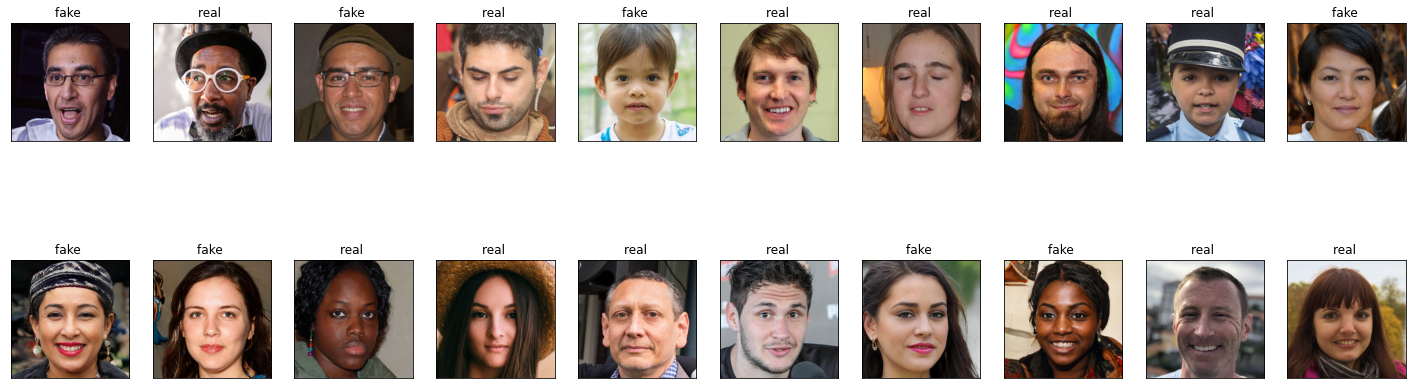

In [ ]:
"""
Plot some training data! 
We need to denormalize PyTorch Tensor first, 
and then change it to images with RGB channel
"""

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
classes = ['fake','real']

# Reverse the normalized value to 0-255
def denormalize(image):
  image = T.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# Display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

dataiter = iter(mini_trains)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

In [ ]:
import torch.nn as nn

In [ ]:
import torch.nn.functional as F
import torch
class MyCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
    self.batch1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
    self.batch2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
    self.batch3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
    self.batch4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
    self.batch5 = nn.BatchNorm2d(256)
    self.fc = nn.Linear(32*32*256, 2)
    self.pool = nn.MaxPool2d(2, 2)
  
  def forward(self, x):
    # N * 3 * 256 * 256
    x = self.conv1(x)
    x = self.batch1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = self.batch2(x)
    x = F.relu(x)
    # x = F.max_pool2d(x, (2,2))
    x = self.pool(x)

    # N * 64 * 128 * 128
    x = self.conv3(x)
    x = self.batch3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = self.batch4(x)
    x = F.relu(x)
    # x = F.max_pool2d(x, (2,2))
    x = self.pool(x)
    
    # N * 128 * 64 * 64
    x = self.conv5(x)
    x = self.batch5(x)
    x = F.relu(x)
    # x = F.max_pool2d(x, (2,2))
    x = self.pool(x)
    
    x =torch.flatten(x, 1)
    return self.fc(x) 

model = MyCNN()

In [ ]:
from torchsummary import summary
summary(model.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
       BatchNorm2d-7        [-1, 128, 128, 128]             256
            Conv2d-8        [-1, 128, 128, 128]         147,584
       BatchNorm2d-9        [-1, 128, 128, 128]             256
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
      BatchNorm2d-12          [-1, 256, 64, 64]             512
        MaxPool2d-13          [-1, 256, 32, 32]               0
           Linear-14                   

In [ ]:
import torch.optim as optim
learning_rate = 1e-5 * 5


In [ ]:
# Choose your optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def evaluate_predictor(loader, model):
  # Turn on evaluation mode on your model
  model.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x, y in loader:
      
      # move tensors to GPU if CUDA is available
      x = x.to(device)
      y = y.to(device)

      # forward pass: compute predicted outputs by passing inputs to the model
      scores = model(x)
      
      # Choose your loss function!
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(scores, y)

      val_loss += loss.item()*x.size(0)
      prediction = scores.data.max(1)[1]
      acc = prediction.eq(y).sum().item()
      val_acc += acc

    # calculate average losses
    val_loss = val_loss / len(mini_vals.dataset)
    val_acc = val_acc / len(mini_vals.dataset)
    print(f'Loss: {val_loss} / Acc: {val_acc}')

In [ ]:
def train(model, optimizer, epochs=1):
  for epoch in range(epochs):
    print('----------------------------')
    print('EPOCH: {}'.format(epoch+1))
    for t, (x, y) in enumerate(mini_trains):  
      # Turn on the training mode on your model
      model.train()
      # move tensors to GPU if CUDA is available
      x = x.to(device)
      y = y.to(device)

      # forward pass: compute predicted outputs by passing inputs to the model
      scores = model(x)
      
      # calculate the batch loss
      # Choose your loss function!
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(scores, y)

      # clear the gradients of all optimized variables
      optimizer.zero_grad()

      loss.backward()

      # perform a single optimization step (parameter update)
      optimizer.step()

      if t % 7 == 0:
        print('Iteration %d, loss = %.4f' % (t, loss.item()))
        evaluate_predictor(mini_vals, model)

In [ ]:
train(model, optimizer, epochs=10)

----------------------------
EPOCH: 1
Iteration 0, loss = 0.7088
Loss: 0.7201236474301675 / Acc: 0.5
Iteration 7, loss = 1.0987
Loss: 0.6943127590281363 / Acc: 0.49872773536895676
Iteration 14, loss = 1.0531
Loss: 0.6997637818484512 / Acc: 0.5006361323155216
Iteration 21, loss = 1.1610
Loss: 0.8923900218410347 / Acc: 0.5
Iteration 28, loss = 0.6981
Loss: 0.7760110185043199 / Acc: 0.5267175572519084
Iteration 35, loss = 0.7026
Loss: 0.7483028303879211 / Acc: 0.5731552162849872
Iteration 42, loss = 0.8348
Loss: 1.004227313983228 / Acc: 0.5248091603053435
Iteration 49, loss = 0.7730
Loss: 1.039765848609934 / Acc: 0.5324427480916031
Iteration 56, loss = 0.7041
Loss: 0.8262150732008858 / Acc: 0.5916030534351145
Iteration 63, loss = 0.6046
Loss: 0.6833715687574624 / Acc: 0.6641221374045801
Iteration 70, loss = 0.6910
Loss: 0.7262354411241663 / Acc: 0.6450381679389313
Iteration 77, loss = 0.4910
Loss: 0.585145087642524 / Acc: 0.7150127226463104
Iteration 84, loss = 0.6938
Loss: 0.569952241792